In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr
from scipy import stats
from scipy.stats import lognorm
import math
from scipy.stats import norm
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
def binear_datos(lista_x, lista_y, bins=50, log = True):
    """
    Dado una lista de par de puntos (X,Y) binea dando lugar a una lista equivalente
    pero de menor dimension. Sirve para eliminar el ruido, variaciones, etc.
    INPUT:
        lista_x (list, array): Lista de puntos de igual dimension que lista_y
        lista_y (list, array): Lista de puntos de igual dimension que lista_x
        bins (int): numero de bins a utilizar
        log (boolean): True-> bins logaritmico, False-> bins lineales
    OUTPUT:
        posiciones (array): Centro de gravedad del bin. lista de posiciones X
        frecuencia_media(array): Frecuencia pesada en los bins
    """
    # Definicion de los bins
    if log:
        bin_edges = np.logspace(np.log10(min(lista_x)), np.log10(max(lista_x)), bins)
    else:
         bin_edges = np.linspace(min(lista_x), max(lista_x), bins)

    diccionario = dict() # valor*posicion
    diccionario_frecs = dict()
    for indice_x, value_x in enumerate(lista_x):
        indice_caja = np.searchsorted(bin_edges, value_x)
        if indice_caja in diccionario:
            diccionario[indice_caja].append(lista_x[indice_x]*lista_y[indice_x])
            diccionario_frecs[indice_caja].append(lista_y[indice_x])
        else:
            diccionario[indice_caja] = list()
            diccionario_frecs[indice_caja] = list()
            diccionario[indice_caja].append(lista_x[indice_x]*lista_y[indice_x])
            diccionario_frecs[indice_caja].append(lista_y[indice_x])

    frecuencia_media = []
    for key, value in diccionario_frecs.items():
        if len(value) > 0:
            frecuencia_media.append(np.mean(value))

        elif len(value) == 0:
            frecuencia_media.append(0)

    posiciones = []
    for key, value in diccionario.items():
        if len(value) > 0:
            posiciones.append(np.sum(value)/np.sum(diccionario_frecs[key]))
        elif len(value) == 0:
            posiciones.append((bin_edges[key] + bin_edges[key+1])/2)
            
    ## Ordenamos los datos
    import pandas as pd
    df = pd.DataFrame({"pos": posiciones, "freqs": frecuencia_media})
    df = df.sort_values("pos")

    posiciones = df.pos.values
    frecuencia_media = df.freqs.values
    
    return posiciones, frecuencia_media

In [3]:
output_dir = "figures/"
data = pd.read_csv("chemicals.csv", index_col=None)
data.head()

,formula,Cs,CAS,MW,feromonas,especies,totaluses,P,A,Al,K,Sy,Alelo
0,C22H44O2,22,36528-28-6,340.58,"['P', 'P']","['Centris analis', 'Pogonomyrmex barbatus']",2,2,0,0,0,0,0
1,C6H12O2,6,868-57-5,116.16,"['A', 'P', 'P', 'Al', 'Al', 'P', 'Al', 'Al', '...","['Cyclocephala literata', 'Graphium doson albi...",19,10,1,8,0,0,9
2,C19H36O2,19,NaN,296.49,"['P', 'P', 'P', 'P', 'P', 'P', 'P']","['Gephyromantis boulengeri', 'Mantella auranti...",7,7,0,0,0,0,0
3,C33H64,33,NaN,460.86,"['P', 'P', 'P']","['Drosophila arizonae', 'Drosophila mojavensis...",3,3,0,0,0,0,0
4,C10H16N2,10,40790-29-2,164.25,"['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', ...","['Dinoroseobacter shibae', 'Loktanella sp', 'T...",11,11,0,0,0,0,0


In [4]:
data.sort_values(by="totaluses", ascending=False)

,formula,Cs,CAS,MW,feromonas,especies,totaluses,P,A,Al,K,Sy,Alelo
482,C2H6O,2,64-17-5,46.07,"['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', ...","['Phylogistostermus dislocatus', 'Panthomorus ...",560,9,540,1,10,0,551
1091,C10H12O4,10,56-25-7,196.20,"['A', 'A', 'A', 'Al', 'Al', 'Al', 'Al', 'A', '...","['Barombiella sp', 'Barombiella vicina', 'Pall...",481,26,359,92,4,0,455
397,C7H6O2,7,553-97-9,122.12,"['Al', 'Al', 'Al', 'A', 'Al', 'Al', 'Al', 'Al'...","['Epanitus obscurus', 'Zadenos delandei', 'Zad...",426,8,25,393,0,0,418
691,C25H52,25,629-99-2,352.68,"['A', 'A', 'P', 'P', 'P', 'P', 'P', 'P', 'P', ...","['Mycodiplosis ligulata', 'Dashyelea sp', 'Cai...",397,381,11,4,1,0,16
518,C27H56,27,593-49-7,380.74,"['P', 'P', 'P', 'P', 'P', 'P', 'P', 'A', 'P', ...","['Cosmophasis bitaeniata', 'Tyreophagus sp', '...",385,380,4,1,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,C27H44O2,27,NaN,400.64,['P'],['Malacosoma americanum'],1,1,0,0,0,0,0
733,C17H32O2,17,NaN,268.43,['P'],['Camponotus arminius'],1,1,0,0,0,0,0
1208,C17H33N,17,NaN,251.45,['P'],['Megalomyrmex antipodum'],1,1,0,0,0,0,0
730,C20H30N2O3,20,NaN,346.46,['Al'],['Macrosiphum albifrons'],1,0,0,1,0,0,1


# 1. Distribution of molecular weights 

In [5]:
x=np.linspace(0.16, 1000, 500)

# Parameters obtained with the script FitData.R
LN_all = stats.lognorm(scale=math.exp(5.403), s= (0.464))
LN_pheromones = stats.lognorm(scale=math.exp(5.426), s=0.47)
LN_alelochem = stats.lognorm(scale=math.exp(5.242), s=0.416)
LN_attracta = stats.lognorm(scale=math.exp(5.201), s=0.395)
LN_allomon = stats.lognorm(scale=math.exp(5.034), s=0.425)
LN_kairo = stats.lognorm(scale=math.exp(5.201), s=0.431)


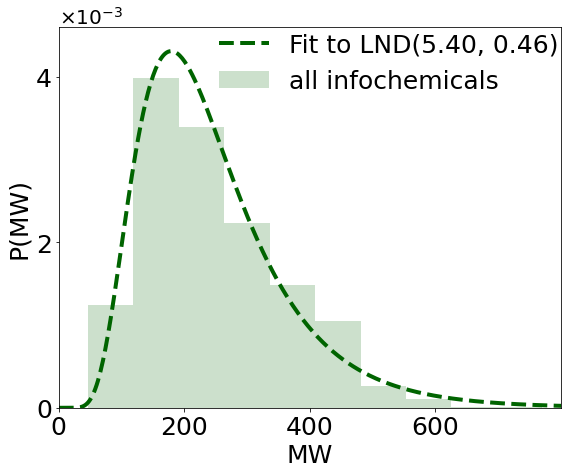

In [6]:
# INFOCHEMICALS
alldata = data[["MW", "totaluses"]]
alldata = alldata[alldata["totaluses"]!=0].reset_index(drop=True)
alldata = alldata["MW"].values

f, ax = plt.subplots(figsize=[9,7])
ax.hist(alldata, density=True, bins=14, label = "all infochemicals", color="darkgreen", alpha=0.2)
ax.plot(x, LN_all.pdf(x), "--", lw=4, label = "Fit to LND(5.40, 0.46)",color="darkgreen",)

ax.set_xlabel("MW", fontsize=25)
ax.set_ylabel("P(MW)", fontsize=25)

ax.set_xlim([0, 800])
ax.set_ylim([0, 0.0046])


ax.set_xticks([0, 200, 400, 600])
ax.set_yticks([0, 0.002, 0.004])
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
ax.yaxis.major.formatter._useMathText = True
ax.yaxis.offsetText.set_fontsize(20)
ax.legend(loc = [0.3,0.8], fontsize=25, frameon=False)
ax.tick_params(axis='both', labelsize=25)



f.savefig("figures/" + "LND_infochemicals.pdf", bbox_inches='tight')

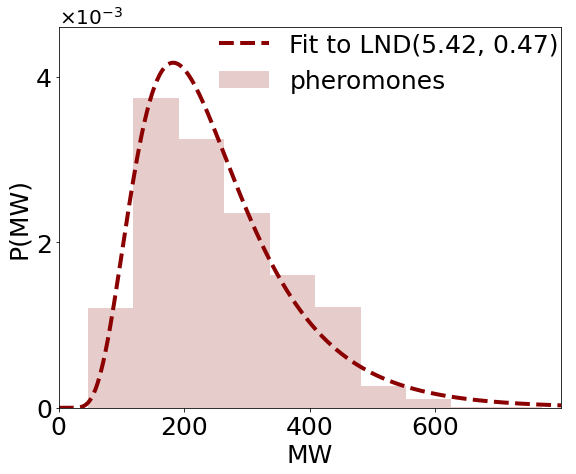

In [7]:
# PHEROMONES
pheromones = data[["MW", "P"]]
pheromones = pheromones[pheromones["P"]!=0].reset_index(drop=True)
pheromones = pheromones["MW"].values

f, ax = plt.subplots(figsize=[9,7])
ax.hist(pheromones, density=True, bins=14, label = "pheromones", color="darkred", alpha=0.2)
ax.plot(x, LN_pheromones.pdf(x), "--", lw=4, label = "Fit to LND(5.42, 0.47)",color="darkred",)

ax.set_xlabel("MW", fontsize=25)
ax.set_ylabel("P(MW)", fontsize=25)

ax.set_xlim([0, 800])
ax.set_ylim([0, 0.0046])


ax.set_xticks([0, 200, 400, 600])
ax.set_yticks([0, 0.002, 0.004])
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
ax.yaxis.major.formatter._useMathText = True
ax.yaxis.offsetText.set_fontsize(20)
ax.legend(loc = [0.3,0.8], fontsize=25, frameon=False)
ax.tick_params(axis='both', labelsize=25)


f.savefig("figures/" + "LND_pheromones.pdf", bbox_inches='tight')

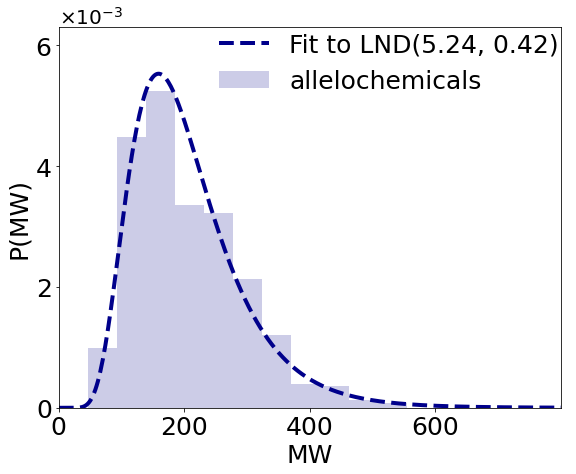

In [8]:
# ALELOCHEMICALS
alelodata = data[["MW", "Alelo"]]
alelodata = alelodata[alelodata["Alelo"]!=0].reset_index(drop=True)
alelodata = alelodata["MW"].values

f, ax = plt.subplots(figsize=[9,7])
ax.hist(alelodata, density=True, bins=11, label = "allelochemicals", color="darkblue", alpha=0.2)
ax.plot(x, LN_alelochem.pdf(x), "--", lw=4, label = "Fit to LND(5.24, 0.42)",color="darkblue",)

ax.set_xlabel("MW", fontsize=25)
ax.set_ylabel("P(MW)", fontsize=25)

ax.set_xlim([0, 800])
ax.set_ylim([0, 0.0063])


ax.set_xticks([0, 200, 400, 600])
ax.set_yticks([0, 0.002, 0.004, 0.006])
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
ax.yaxis.major.formatter._useMathText = True
ax.yaxis.offsetText.set_fontsize(20)
ax.legend(loc = [0.3,0.8], fontsize=25, frameon=False)
ax.tick_params(axis='both', labelsize=25)

f.savefig("figures/" + "LND_alelochemicals.pdf", bbox_inches='tight')

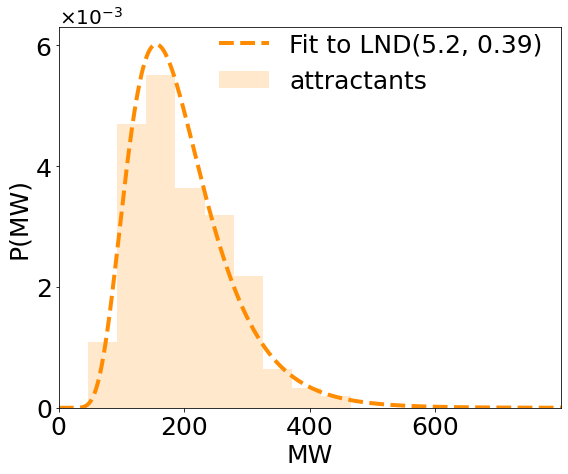

In [9]:
# ATTRACTANS
attractans = data[["MW", "A"]]
attractans = attractans[attractans["A"]!=0].reset_index(drop=True)
attractans = attractans["MW"].values

f, ax = plt.subplots(figsize=[9,7])
ax.hist(attractans, density=True, bins=9, label = "attractants", color="darkorange", alpha=0.2)
ax.plot(x, LN_attracta.pdf(x), "--", lw=4, label = "Fit to LND(5.2, 0.39)",color="darkorange",)

ax.set_xlabel("MW", fontsize=25)
ax.set_ylabel("P(MW)", fontsize=25)

ax.set_xlim([0, 800])
ax.set_ylim([0, 0.0063])


ax.set_xticks([0, 200, 400, 600])
ax.set_yticks([0, 0.002, 0.004, 0.006])
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
ax.yaxis.major.formatter._useMathText = True
ax.yaxis.offsetText.set_fontsize(20)
ax.legend(loc = [0.3,0.8], fontsize=25, frameon=False)
ax.tick_params(axis='both', labelsize=25)

f.savefig("figures/" + "LND_attractans.pdf", bbox_inches='tight')

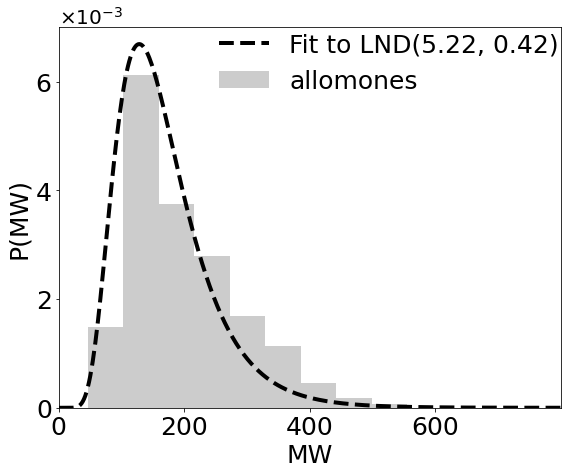

In [10]:
# ALLOMONES
allomon = data[["MW", "Al"]]
allomon = allomon[allomon["Al"]!=0].reset_index(drop=True)
allomon = allomon["MW"].values

f, ax = plt.subplots(figsize=[9,7])
ax.hist(allomon, density=True, bins=9, label = "allomones", color="black", alpha=0.2)
ax.plot(x, LN_allomon.pdf(x), "--", lw=4, label = "Fit to LND(5.22, 0.42)",color="black",)

ax.set_xlabel("MW", fontsize=25)
ax.set_ylabel("P(MW)", fontsize=25)

ax.set_xlim([0, 800])
ax.set_ylim([0, 0.007])


ax.set_xticks([0, 200, 400, 600])
ax.set_yticks([0, 0.002, 0.004, 0.006])
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
ax.yaxis.major.formatter._useMathText = True
ax.yaxis.offsetText.set_fontsize(20)
ax.legend(loc = [0.3,0.8], fontsize=25, frameon=False)
ax.tick_params(axis='both', labelsize=25)

f.savefig("figures/" + "LND_allomones.pdf", bbox_inches='tight')

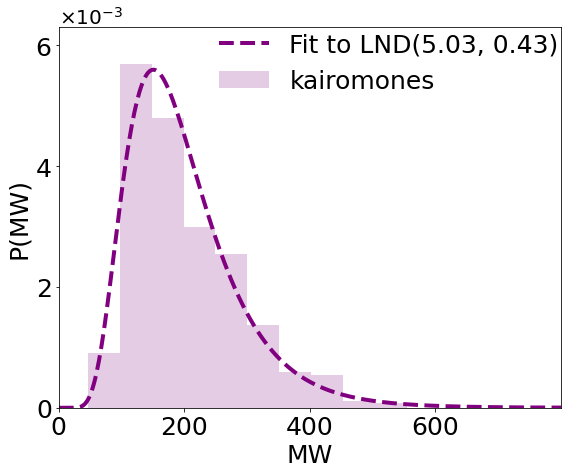

In [11]:
# Kairomones
kairom = data[["MW", "K"]]
kairom = kairom[kairom["K"]!=0].reset_index(drop=True)
kairom = kairom["MW"].values

f, ax = plt.subplots(figsize=[9,7])
ax.hist(allomon, density=True, bins=10, label = "kairomones", color="purple", alpha=0.2)
ax.plot(x, LN_kairo.pdf(x), "--", lw=4, label = "Fit to LND(5.03, 0.43)",color="purple",)

ax.set_xlabel("MW", fontsize=25)
ax.set_ylabel("P(MW)", fontsize=25)

ax.set_xlim([0, 800])
ax.set_ylim([0, 0.0063])


ax.set_xticks([0, 200, 400, 600])
ax.set_yticks([0, 0.002, 0.004, 0.006])
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
ax.yaxis.major.formatter._useMathText = True
ax.yaxis.offsetText.set_fontsize(20)
ax.legend(loc = [0.3,0.8], fontsize=25, frameon=False)
ax.tick_params(axis='both', labelsize=25)

f.savefig("figures/" + "LND_kairomones.pdf", bbox_inches='tight')

# 2. Distribution of Carbons

# 3. Correlation MW and degree

coefficient of determination: 0.9365531349336542
intercept: 33.2107894651399
slope: [13.5671666]


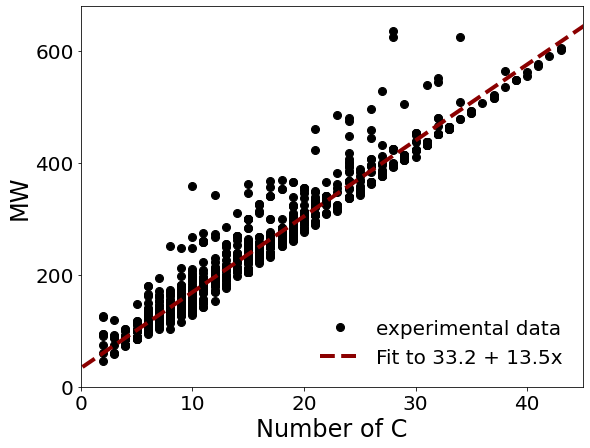

In [35]:
f, ax = plt.subplots(figsize=[9,7])
xdata = data.Cs.values
ydata = data.MW.values

x = xdata.reshape((-1, 1))
y = ydata
model = LinearRegression()
model.fit(x, y)
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

x_synt=np.linspace(0.16, 1000, 500)

ax.plot(xdata, ydata, 'o', color="black", label= "experimental data", ms=8)
ax.plot(x_synt, model.coef_[0]*x_synt + model.intercept_, '--', lw=4, color="darkred", label = "Fit to 33.2 + 13.5x")

ax.set_ylabel("MW", fontsize=24)
ax.set_xlabel("Number of C", fontsize=24)
ax.set_ylim([0, 680])
ax.set_xlim([0, 45])


ax.set_yticks([0, 200, 400, 600])
ax.set_xticks([0, 10, 20, 30, 40])
ax.tick_params(axis='both', labelsize=20)


ax.legend(loc = [0.46,0.03], fontsize=20, frameon=False)



f.savefig("figures/" + "MW_Cs.pdf", bbox_inches='tight')

# 4. Brevity Law MW and degree



In [45]:
def func_exp(x, a, b):
    return a * np.exp(-b * x)

def func_log(x, a, b): # FUNCION LOGARITMICA que utiliza los mismos parametros
    return 1/(-b) * ( np.log(x) - np.log(a) )

R2: 0.0267205706448842


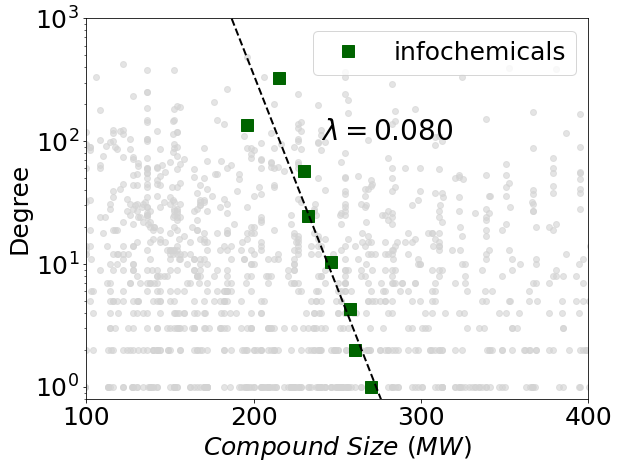

In [46]:
brevity_all = data[["MW", "totaluses"]]
brevity_all = brevity_all[brevity_all["totaluses"]!=0].reset_index(drop=True) 
brevity_all.columns = ["MW", "degree"]
df = brevity_all

bins=10
color="darkgreen"
label = "infochemicals"

f, ax = plt.subplots(figsize=(9,7))
ax.plot(df.MW, df.degree, 'o', lw = 1, ms = 6, zorder=2, alpha=0.6, color = 'lightgrey')

freq, pos = binear_datos(df.degree, df.MW, bins=8, log = True)
ax.plot(pos, freq, 's', lw = 2, ms = 12, label = label, zorder=2, alpha=1, color=color)

ax.set_xlabel(r"$Compound$"  + " " + r"$Size$"  + " " + r"$ (MW)$", fontsize=25)
ax.set_ylabel("Degree", fontsize=25)
ax.legend(frameon = True, loc = 1, fontsize=25)
ax.set_yscale("log")
ax.set_ylim([0.8,1000])
ax.set_xlim([120,300])
ax.set_xticks([100, 200, 300, 400])

ax.tick_params(axis='both', labelsize=25)

xplot = x=np.linspace(np.min(x), np.max(x), 3)

x = df.degree.values
y = df.MW.values

popt, pcov = curve_fit(func_log, x, y, p0=[500, 0.5])
ax.plot(xplot, func_exp(xplot, *popt), "--", color = "black", lw = 2)
ax.text(0.6, 0.7, r'$\lambda = $' + "{:.{}f}".format(popt[1], 3), horizontalalignment='center', fontsize = 28, verticalalignment='center', transform=ax.transAxes)


residuals = y - func_log(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R2: " + str(r_squared))

f.savefig("figures/Brevity_MW_Infochemicals.pdf", bbox_inches = 'tight', pad_inches = 0.1)

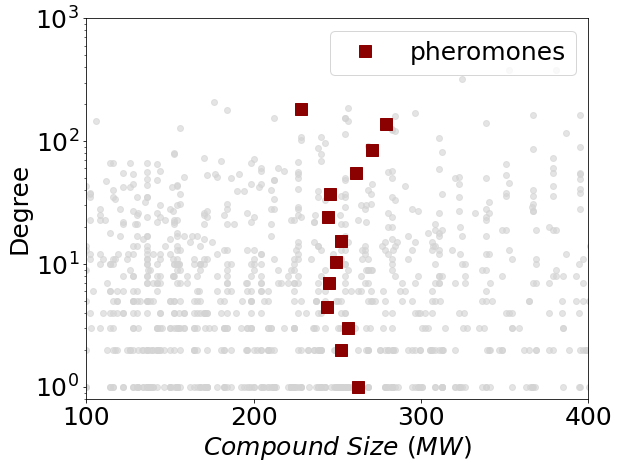

In [47]:
brevity_all = data[["MW", "P"]]
brevity_all = brevity_all[brevity_all["P"]!=0].reset_index(drop=True) 
brevity_all.columns = ["MW", "degree"]
df = brevity_all

bins=15
color="darkred"
label = "pheromones"

f, ax = plt.subplots(figsize=(9,7))
ax.plot(df.MW, df.degree, 'o', lw = 1, ms = 6, zorder=2, alpha=0.6, color = 'lightgrey')

freq, pos = binear_datos(df.degree, df.MW, bins=bins, log = True)
ax.plot(pos[0:-1], freq[0:-1], 's', lw = 2, ms = 12, label = label, zorder=2, alpha=1, color=color)

ax.set_xlabel(r"$Compound$"  + " " + r"$Size$"  + " " + r"$ (MW)$", fontsize=25)
ax.set_ylabel("Degree", fontsize=25)
ax.legend(frameon = True, loc = 1, fontsize=25)
ax.set_yscale("log")
ax.set_ylim([0.8,1000])
ax.set_xlim([120,300])
ax.set_xticks([100, 200, 300, 400])

ax.tick_params(axis='both', labelsize=25)



x = df.degree.values
y = df.MW.values
#popt, pcov = curve_fit(func_log, x, y, p0=[500, 0.5])
#ax.plot(xplot, func_exp(xplot, *popt), "--", color = "black", lw = 2)
#ax.text(0.6, 0.6, r'$\lambda = $' + "{:.{}f}".format(popt[1], 3), horizontalalignment='center', fontsize = 15, verticalalignment='center', transform=ax.transAxes)


#residuals = y - func_log(x, *popt)
#ss_res = np.sum(residuals**2)
#ss_tot = np.sum((y-np.mean(y))**2)
#r_squared = 1 - (ss_res / ss_tot)
#print("R2: " + str(r_squared))

f.savefig("figures/Brevity_MW_Pheromones.pdf", bbox_inches = 'tight', pad_inches = 0.1)

R2: 0.10059713839624551


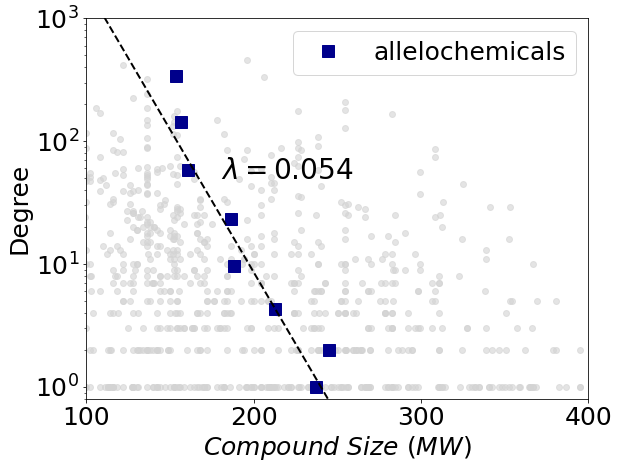

In [48]:
brevity_all = data[["MW", "Alelo"]]
brevity_all = brevity_all[brevity_all["Alelo"]!=0].reset_index(drop=True) 
brevity_all.columns = ["MW", "degree"]
df = brevity_all

bins=8
color="darkblue"
label = "allelochemicals"

f, ax = plt.subplots(figsize=(9,7))
ax.plot(df.MW, df.degree, 'o', lw = 1, ms = 6, zorder=2, alpha=0.6, color = 'lightgrey')

freq, pos = binear_datos(df.degree, df.MW, bins=bins, log = True)
ax.plot(pos, freq, 's', lw = 2, ms = 12, label = label, zorder=2, alpha=1, color=color)

ax.set_xlabel(r"$Compound$"  + " " + r"$Size$"  + " " + r"$ (MW)$", fontsize=25)
ax.set_ylabel("Degree", fontsize=25)
ax.legend(frameon = True, loc = 1, fontsize=25)
ax.set_yscale("log")
ax.set_ylim([0.8,1000])
ax.set_xlim([120,300])
ax.set_xticks([100, 200, 300, 400])

ax.tick_params(axis='both', labelsize=25)



x = df.degree.values
y = df.MW.values
popt, pcov = curve_fit(func_log, x, y, p0=[500, 0.5])
ax.plot(xplot, func_exp(xplot, *popt), "--", color = "black", lw = 2)
ax.text(0.4, 0.6, r'$\lambda = $' + "{:.{}f}".format(popt[1], 3), horizontalalignment='center', fontsize = 28, verticalalignment='center', transform=ax.transAxes)


residuals = y - func_log(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R2: " + str(r_squared))

f.savefig("figures/Brevity_MW_Alelochemicals.pdf", bbox_inches = 'tight', pad_inches = 0.1)

R2: 0.0500112641869922


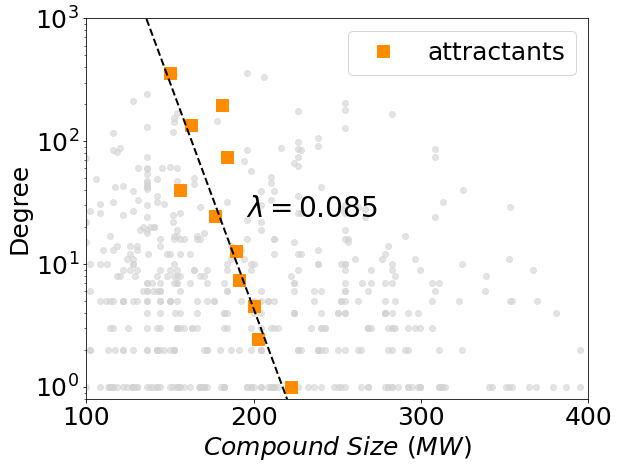

In [49]:
brevity_all = data[["MW", "A"]]
brevity_all = brevity_all[brevity_all["A"]!=0].reset_index(drop=True) 
brevity_all.columns = ["MW", "degree"]
df = brevity_all

bins=12
color="darkorange"
label = "attractants"

f, ax = plt.subplots(figsize=(9,7))
ax.plot(df.MW, df.degree, 'o', lw = 1, ms = 6, zorder=2, alpha=0.6, color = 'lightgrey')

freq, pos = binear_datos(df.degree, df.MW, bins=bins, log = True)
ax.plot(pos, freq, 's', lw = 2, ms = 12, label = label, zorder=2, alpha=1, color=color)

ax.set_xlabel(r"$Compound$"  + " " + r"$Size$"  + " " + r"$ (MW)$", fontsize=25)
ax.set_ylabel("Degree", fontsize=25)
ax.legend(frameon = True, loc = 1, fontsize=25)
ax.set_yscale("log")
ax.set_ylim([0.8,1000])
ax.set_xlim([120,300])
ax.set_xticks([100, 200, 300, 400])

ax.tick_params(axis='both', labelsize=25)



x = df.degree.values
y = df.MW.values
popt, pcov = curve_fit(func_log, x, y, p0=[500, 0.5])
ax.plot(xplot, func_exp(xplot, *popt), "--", color = "black", lw = 2)
ax.text(0.45, 0.5, r'$\lambda = $' + "{:.{}f}".format(popt[1], 3), horizontalalignment='center', fontsize = 28, verticalalignment='center', transform=ax.transAxes)


residuals = y - func_log(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R2: " + str(r_squared))

f.savefig("figures/Brevity_MW_Atractans.pdf", bbox_inches = 'tight', pad_inches = 0.1)

R2: 0.0880220693827497


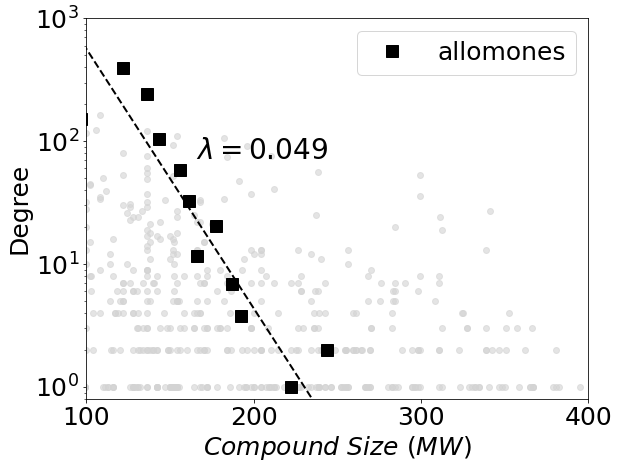

In [50]:
brevity_all = data[["MW", "Al"]]
brevity_all = brevity_all[brevity_all["Al"]!=0].reset_index(drop=True) 
brevity_all.columns = ["MW", "degree"]
df = brevity_all

bins=12
color="black"
label = "allomones"

f, ax = plt.subplots(figsize=(9,7))
ax.plot(df.MW, df.degree, 'o', lw = 1, ms = 6, zorder=2, alpha=0.6, color = 'lightgrey')

freq, pos = binear_datos(df.degree, df.MW, bins=bins, log = True)
ax.plot(pos, freq, 's', lw = 2, ms = 12, label = label, zorder=2, alpha=1, color=color)

ax.set_xlabel(r"$Compound$"  + " " + r"$Size$"  + " " + r"$ (MW)$", fontsize=25)
ax.set_ylabel("Degree", fontsize=25)
ax.legend(frameon = True, loc = 1, fontsize=25)
ax.set_yscale("log")
ax.set_ylim([0.8,1000])
ax.set_xlim([120,300])
ax.set_xticks([100, 200, 300, 400])

ax.tick_params(axis='both', labelsize=25)



x = df.degree.values
y = df.MW.values
popt, pcov = curve_fit(func_log, x, y, p0=[500, 0.5])
ax.plot(xplot, func_exp(xplot, *popt), "--", color = "black", lw = 2)
ax.text(0.35, 0.65, r'$\lambda = $' + "{:.{}f}".format(popt[1], 3), horizontalalignment='center', fontsize = 28, verticalalignment='center', transform=ax.transAxes)


residuals = y - func_log(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R2: " + str(r_squared))

f.savefig("figures/Brevity_MW_Allomones.pdf", bbox_inches = 'tight', pad_inches = 0.1)

<ipython-input-45-b572acffd8a3>:5: RuntimeWarning: invalid value encountered in log
  return 1/(-b) * ( np.log(x) - np.log(a) )


R2: 0.06899627403538444


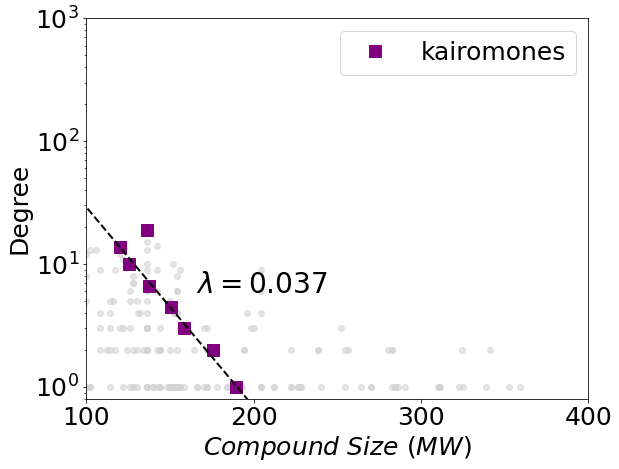

In [51]:
brevity_all = data[["MW", "K"]]
brevity_all = brevity_all[brevity_all["K"]!=0].reset_index(drop=True) 
brevity_all.columns = ["MW", "degree"]
df = brevity_all

bins=8
color="purple"
label = "kairomones"

f, ax = plt.subplots(figsize=(9,7))
ax.plot(df.MW, df.degree, 'o', lw = 1, ms = 6, zorder=2, alpha=0.6, color = 'lightgrey')

freq, pos = binear_datos(df.degree, df.MW, bins=bins, log = True)
ax.plot(pos, freq, 's', lw = 2, ms = 12, label = label, zorder=2, alpha=1, color=color)

ax.set_xlabel(r"$Compound$"  + " " + r"$Size$"  + " " + r"$ (MW)$", fontsize=25)
ax.set_ylabel("Degree", fontsize=25)
ax.legend(frameon = True, loc = 1, fontsize=25)
ax.set_yscale("log")
ax.set_ylim([0.8,1000])
ax.set_xlim([120,300])
ax.set_xticks([100, 200, 300, 400])

ax.tick_params(axis='both', labelsize=25)



x = df.degree.values
y = df.MW.values
popt, pcov = curve_fit(func_log, x, y, p0=[500, 0.5])
ax.plot(xplot, func_exp(xplot, *popt), "--", color = "black", lw = 2)
ax.text(0.35, 0.3, r'$\lambda = $' + "{:.{}f}".format(popt[1], 3), horizontalalignment='center', fontsize = 28, verticalalignment='center', transform=ax.transAxes)


residuals = y - func_log(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R2: " + str(r_squared))

f.savefig("figures/Brevity_MW_Kairomones.pdf", bbox_inches = 'tight', pad_inches = 0.1)

# 2. Entropy estimation

In [43]:
#totaluses	P	A	Al	K	Sy	Alelo

def entropy_rank(name):

    P = np.asarray(data[name].sort_values(ascending=False).reset_index(drop=True).tolist())
    P =P[P!=0]
    P = P/sum(P)
    num_bins=100

    size_bin= int(len(P)/num_bins)
    #size_bin = 10
    flag = 0
    list_Pbin = []
    P_bin =0

    for i,item in enumerate(P):
        P_bin += item
        flag +=1
        if (flag >= size_bin) and (len(list_Pbin)!=num_bins-1):
            list_Pbin.append(P_bin)
            flag=0
            P_bin=0
    list_Pbin.append(P_bin) # LAST ITEM
    #assert len(list_Pbin) == num_bins

    #print(list_Pbin)
    H = 0
    for item in list_Pbin:
        H += item * np.log2(item)
    
    return(-H)

print(entropy_rank("totaluses"))
print(entropy_rank("P"))
print(entropy_rank("Alelo"))
print(entropy_rank("A"))
print(entropy_rank("Al"))
print(entropy_rank("K"))


5.302376025975908
5.436273240861429
5.083091580026022
5.076802336680599
5.0527284292761765
6.05920964648695


## 3. Entropy estimation Naive Bayes

In [38]:
#totaluses	P	A	Al	K	Sy	Alelo

def entroy_naives(name):
    P = np.asarray(data[name].sort_values(ascending=False).reset_index(drop=True).tolist())
    P =P[P!=0]
    P = P/sum(P)
    #print(sum(P))
    H = np.sum(P*np.log2(P))
    return(-H)

print(entroy_naives("totaluses"))
print(entroy_naives("P"))
print(entroy_naives("Alelo"))
print(entroy_naives("A"))
print(entroy_naives("Al"))
print(entroy_naives("K"))


9.007437710162755
8.896341825350207
8.07697770247699
7.398508719667252
7.345081962627999
7.060711353162539


In [27]:
np.sum(P*np.log2(P))

-9.007437710162755